In [1]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from glob import glob
from itertools import chain


from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [2]:
p = plt.rcParams
p["scatter.marker"] = '.'
p["lines.markersize"] = 1

In [3]:
def process(filename, headers, datas):
    header = np.loadtxt(filename, delimiter='\t', skiprows=1, max_rows=1, unpack=True)
    p, d, G, A, f, I_chauffage, V_polarisation, V_grill = header
    headers.append(header)

    data = np.loadtxt(filename, delimiter='\t', skiprows=2, unpack=True)
    V_in, V_out, *_ = data
    I_out = V_out / (10 * G)

    values, counts = np.unique_counts(V_in)
    V_in_combined = np.zeros_like(values)
    I_out_combined = np.zeros_like(values)
    I_out_std_combined = np.zeros_like(values)
    for i, (value, count) in enumerate(zip(values, counts)):
        idx = np.nonzero(V_in == value)
        V_in_combined[i] = value
        I_out_combined[i] = np.mean(I_out[idx])
        I_out_std_combined[i] = np.std(I_out[idx])

    datas.append(np.array((V_in_combined, I_out_combined, I_out_std_combined)))

In [4]:
all_headers = [[], []]
all_datas = [[], []]
for run in glob('../data/position_pression/1.3e-3/*'):
    process(run, all_headers[0], all_datas[0])
for run in glob('../data/position_pression/1.2e-3v2/*'):
    process(run, all_headers[1], all_datas[1])
all_headers[0][0][0], all_headers[1][0][0]

(np.float64(0.0013), np.float64(0.0012))

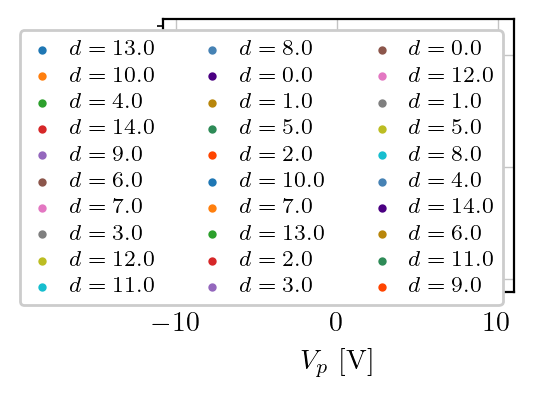

In [5]:
fig, ax = plt.subplots(1,1, dpi=200)
colors = list(plt.cm.tab10(np.arange(10))) + ["steelblue", "indigo", "darkgoldenrod", "seagreen", "orangered"]
ax.set_prop_cycle('color', colors)
plt.xlabel("$V_p$ [V]")
plt.ylabel("$I_p$ [A]")
for headers, datas in zip(all_headers, all_datas):
    for header, data in zip(headers, datas):
        p, d, G, A, f, I_chauffage, V_polarisation, V_grill = header
        V_in, I_out, I_out_std = data

        plt.scatter(V_in, I_out, label=f"$d = {d}$")

plt.legend(ncols=3, fontsize=8, markerscale=4)

## Find V_{sp}, ln(I_{es})

In [6]:
def set_all_between(arr):
    idx = np.nonzero(arr)[0]
    idx_start, idx_stop = idx[0], idx[-1]
    arr[idx_start:idx_stop+1] = True
    return arr

In [7]:
T_e = unp.uarray(np.zeros((len(all_datas), len(all_datas[0]))), np.zeros((len(all_datas), len(all_datas[0]))))
T = unp.uarray(np.zeros((len(all_datas), len(all_datas[0]))), np.zeros((len(all_datas), len(all_datas[0]))))
n_e = unp.uarray(np.zeros((len(all_datas), len(all_datas[0]))), np.zeros((len(all_datas), len(all_datas[0]))))

B_fit_start = np.array(np.ones((len(all_datas), len(all_datas[0])))*0)
B_fit_stop = np.array(np.ones((len(all_datas), len(all_datas[0])))*3.5)
C_fit_start = np.array(np.ones((len(all_datas), len(all_datas[0])))*7)

B_fit_start[0,0] = 1.5
B_fit_stop[0,0] = 4
B_fit_start[0,14] = 2
B_fit_stop[0,14] = 4
B_fit_start[1,:] = 1
B_fit_stop[1,:] = 3

for i, (headers, datas) in enumerate(zip(all_headers, all_datas)):
    for j, (header, data) in enumerate(zip(headers, datas)):
        print(f"Plot {i},{j}")
        p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
        V_in, I_out, I_out_std = data

        dydx = np.gradient(np.log(I_out), V_in)
        threshold = 7e-2
        idx = np.abs(np.diff(dydx, prepend=0)) < threshold
        idx = np.logical_and(idx, V_in > B_fit_start[i,j])
        idx_B = set_all_between(np.logical_and(idx, V_in < B_fit_stop[i,j]))
        idx_C = set_all_between(np.logical_and(idx, V_in > C_fit_start[i,j]))
        # idx_B = np.logical_and(0 < V_in, V_in < 3)
        # idx_C = V_in > 6

        coefsB, covB = np.polyfit(V_in[idx_B], np.log(I_out[idx_B]), 1, cov=True)
        coefs_errB = unp.uarray(coefsB, np.sqrt(np.diag(covB)))
        fitfuncB = np.poly1d(coefsB)
        coefsC, covC = np.polyfit(V_in[idx_C], np.log(I_out[idx_C]), 1, cov=True)
        coefs_errC = unp.uarray(coefsC, np.sqrt(np.diag(covC)))
        fitfuncC = np.poly1d(coefsC)

        x = np.linspace(V_in[0], V_in[-1])
        plt.scatter(V_in, np.log(I_out), c='k')
        plt.plot(x, fitfuncB(x))
        plt.plot(x, fitfuncC(x))

        V_sp = -(coefs_errC[1] - coefs_errB[1]) / (coefs_errC[0] - coefs_errB[0])
        I_sp = umath.exp(coefs_errB[0] * V_sp + coefs_errB[1])
        print(V_sp, I_sp)
        plt.axvline(V_sp.n)
        plt.axhline(umath.log(I_sp).n)

        T_e_run = 1/coefs_errB[0] * ELEMENTARY_CHARGE / BOLTZMANN_CONSTANT_JOULE
        T_e_run += ufloat(0,0.12e4)
        T_run = T_e_run * BOLTZMANN_CONSTANT_ELECTRONVOLT
        # TODO: verifier unitées
        n_e_run = 4 / (ELEMENTARY_CHARGE * SURFACE_PROBE) * unp.sqrt(2 * np.pi * ELECTRON_MASS / (BOLTZMANN_CONSTANT_JOULE * T_e_run)) * I_sp
        print(f"{T_e_run = :.1ueP}, {T_run = :.1ueP}, {n_e_run = :.1ueP}")
        T_e[i, j] = T_e_run
        T[i, j] = T_run
        n_e[i, j] = n_e_run

        plt.gcf().delaxes(plt.gca())
        # plt.show()


Plot 0,0
4.43+/-0.09 0.00197+/-0.00004
T_e_run = (2.5±0.1)×10⁴, T_run = (2.2±0.1)×10⁰, n_e_run = (1.57±0.05)×10¹⁶
Plot 0,1
4.86+/-0.08 0.00248+/-0.00004
T_e_run = (2.6±0.1)×10⁴, T_run = (2.2±0.1)×10⁰, n_e_run = (1.96±0.06)×10¹⁶
Plot 0,2
5.06+/-0.10 0.00287+/-0.00005
T_e_run = (2.6±0.1)×10⁴, T_run = (2.2±0.1)×10⁰, n_e_run = (2.28±0.06)×10¹⁶
Plot 0,3
3.93+/-0.06 0.001429+/-0.000019
T_e_run = (2.8±0.1)×10⁴, T_run = (2.4±0.1)×10⁰, n_e_run = (1.09±0.03)×10¹⁶
Plot 0,4
4.90+/-0.11 0.00258+/-0.00005
T_e_run = (2.6±0.1)×10⁴, T_run = (2.3±0.1)×10⁰, n_e_run = (2.04±0.06)×10¹⁶
Plot 0,5
4.90+/-0.07 0.00275+/-0.00004
T_e_run = (2.5±0.1)×10⁴, T_run = (2.2±0.1)×10⁰, n_e_run = (2.20±0.06)×10¹⁶
Plot 0,6
4.91+/-0.10 0.00271+/-0.00004
T_e_run = (2.6±0.1)×10⁴, T_run = (2.2±0.1)×10⁰, n_e_run = (2.15±0.06)×10¹⁶
Plot 0,7
5.18+/-0.10 0.00294+/-0.00005
T_e_run = (2.7±0.1)×10⁴, T_run = (2.3±0.1)×10⁰, n_e_run = (2.30±0.07)×10¹⁶
Plot 0,8
4.74+/-0.09 0.00222+/-0.00005
T_e_run = (2.7±0.1)×10⁴, T_run = (2.3±0.1)×10⁰,

/tmp/ipykernel_26537/3755479718.py:22: RuntimeWarning: invalid value encountered in log
  dydx = np.gradient(np.log(I_out), V_in)
/tmp/ipykernel_26537/3755479718.py:39: RuntimeWarning: invalid value encountered in log
  plt.scatter(V_in, np.log(I_out), c='k')


T_e_run = (2.7±0.1)×10⁴, T_run = (2.3±0.1)×10⁰, n_e_run = (2.23±0.06)×10¹⁶
Plot 1,4
4.81+/-0.10 0.00284+/-0.00005
T_e_run = (2.6±0.1)×10⁴, T_run = (2.2±0.1)×10⁰, n_e_run = (2.26±0.06)×10¹⁶
Plot 1,5
5.50+/-0.13 0.00311+/-0.00008
T_e_run = (3.2±0.1)×10⁴, T_run = (2.8±0.1)×10⁰, n_e_run = (2.20±0.07)×10¹⁶
Plot 1,6
4.49+/-0.15 0.00219+/-0.00005
T_e_run = (2.6±0.1)×10⁴, T_run = (2.2±0.1)×10⁰, n_e_run = (1.74±0.05)×10¹⁶
Plot 1,7
5.21+/-0.10 0.00299+/-0.00005
T_e_run = (2.9±0.1)×10⁴, T_run = (2.5±0.1)×10⁰, n_e_run = (2.24±0.06)×10¹⁶
Plot 1,8
4.60+/-0.08 0.00272+/-0.00004
T_e_run = (2.5±0.1)×10⁴, T_run = (2.1±0.1)×10⁰, n_e_run = (2.20±0.06)×10¹⁶
Plot 1,9
4.42+/-0.09 0.00258+/-0.00006
T_e_run = (2.5±0.1)×10⁴, T_run = (2.1±0.1)×10⁰, n_e_run = (2.10±0.07)×10¹⁶
Plot 1,10
4.66+/-0.12 0.00279+/-0.00007
T_e_run = (2.5±0.1)×10⁴, T_run = (2.1±0.1)×10⁰, n_e_run = (2.27±0.08)×10¹⁶
Plot 1,11
3.99+/-0.08 0.001633+/-0.000033
T_e_run = (2.7±0.1)×10⁴, T_run = (2.3±0.1)×10⁰, n_e_run = (1.27±0.04)×10¹⁶
Plot 1,12

<Figure size 294.291x230.315 with 0 Axes>

In [8]:
distances_old = list(map(lambda header: header[1], all_headers[0]))
distances_new = list(map(lambda header: header[1], all_headers[1]))

In [9]:
p = plt.rcParams
# p["figure.figsize"] = (5.75*CM_PER_INCH, 4.5*CM_PER_INCH)
p['savefig.bbox'] = 'standard'
p["figure.subplot.left"]   = 0.21
p['figure.subplot.right']  = 0.97
p['figure.subplot.top']    = 0.9
p['figure.subplot.bottom'] = 0.22

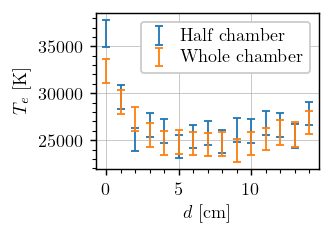

In [10]:
plt.errorbar(distances_old, nom_vals(T_e[0]), yerr=std_devs(T_e[0]), ls='',
             label='Half chamber')
plt.errorbar(distances_new, nom_vals(T_e[1]), yerr=std_devs(T_e[1]), ls='',
             label='Whole chamber')
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$T_e$ [K]')
plt.legend()

plt.savefig("../figures/temperatureK_position_twofilaments.pdf")

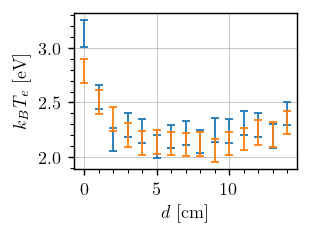

In [11]:
plt.errorbar(distances_old, nom_vals(T[0]), yerr=std_devs(T[0]), ls='')
plt.errorbar(distances_new, nom_vals(T[1]), yerr=std_devs(T[1]), ls='')
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$k_B T_e$ [eV]')

plt.savefig("../figures/temperatureeV_position_twofilaments.pdf")

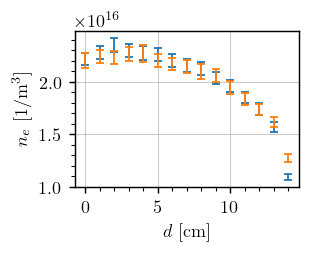

In [12]:
plt.errorbar(distances_old, nom_vals(n_e[0]), yerr=std_devs(n_e[0]), ls='')
plt.errorbar(distances_new, nom_vals(n_e[1]), yerr=std_devs(n_e[1]), ls='')
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$n_e$ $[1/$m$^3]$')

plt.savefig("../figures/density_position_twofilaments.pdf")